# Authors
* Andy Zhang (zhan3139@purdue.edu) - Purdue BS/MS in ME 2023 

# About
* compare and contrast SVM and ANN models with HVAC data from onsite at Indy
* Please consider the following guides and resources that I used to help build these models 

# Helpful Resources
* correlation matrix -> https://datagy.io/python-correlation-matrix/

# SVC for regression
* https://towardsdatascience.com/svm-support-vector-machine-for-classification-710a009f6873

# ANN for regression 
* https://thinkingneuron.com/using-artificial-neural-networks-for-regression-in-python/



**load data**

In [2]:
import pandas as pd
import io
from google.colab import files

# load 'Chiller and Weather 11-6.csv' from local device
uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['Chiller and Weather 11-6.csv']))

# dataset.head() prints out the first 5 rows of the data, letes us double check that everything looks good before we begin preprocessing data
dataset.head()

Saving Chiller and Weather 11-6.csv to Chiller and Weather 11-6.csv


,Time,Temp,RH,Dewpt,WindSpd,ChillWaterPump1Output,ChillWaterPump2Output,ChillWaterReturnTemp,ChillWaterSupplyTemp,ChillWaterSystemFlow,ChillWaterPumpOutput,EnergyConsumption,BuildingLoad
0,9/8/2022 20:00,71.000000,56.00,55.0,6.0,45.0,45.0,11.111111,7.777778,13.336811,0.9,167.403649,138.293657
1,9/8/2022 20:01,70.983333,56.05,55.0,6.0,45.0,45.0,11.111111,7.777778,13.161070,0.9,165.197745,138.955356
2,9/8/2022 20:02,70.966667,56.10,55.0,6.0,45.0,45.0,11.111111,7.777778,13.274334,0.9,166.619439,138.753560
3,9/8/2022 20:03,70.950000,56.15,55.0,6.0,45.0,45.0,11.111111,7.777778,13.233203,0.9,166.103158,139.515174
4,9/8/2022 20:04,70.933333,56.20,55.0,6.0,45.0,45.0,11.111111,7.777778,13.192978,0.9,165.598260,139.216458


**preprocess data** - specify output variable here

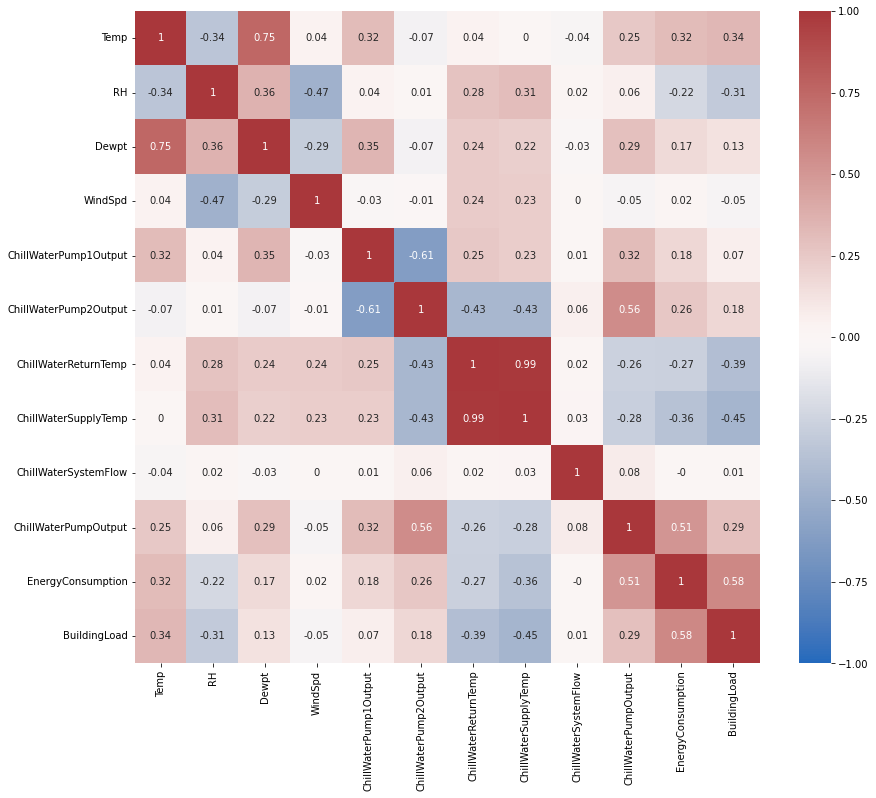

Temp                    0.32
ChillWaterSupplyTemp   -0.36
ChillWaterPumpOutput    0.51
EnergyConsumption       1.00
BuildingLoad            0.58
dtype: float64


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## specify output variable here


## correlation matrix - each value in the matrix relates the row and colomn value, values closer to 1 or -1 represent strongest positive or negative correlation possible 

# make the correlation matrix plot larger for easier reading
plt.rcParams["figure.figsize"] = (14,12)

# build correlation matrix
matrix = dataset.corr().round(2)
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

# filter strong correlations 
corValue = 0.30 # set this value based off what correlation matrix plot, what value do you think represents a strong relationship between the output and input varaibles? 
matrix = matrix.unstack()
matrix = matrix[abs(matrix) >= corValue] 
print(matrix.EnergyConsumption) # only interested in EnergyConsumption, need to specify output varaible here

Optimizations to be added here
* Automatically set the following based on modelMatrix (correlation matrix with just the y parameter of interest)
* y : set it equal to modelMatrix.idxmax()
* x : set it equal to the rest of the labels in modelMatrix

How?
* unstacked correlation matrix is a pd.series with a pd.MultiIndex --> likely the key to understand how to optimize procedures at this part


In [55]:
## experimentation with data preprocessing, auto setting X and y 
modelMatrix = matrix.EnergyConsumption
print(modelMatrix)

## y variables

# isolates output variable into yVal
yVal = modelMatrix.idxmax() # since output variable has the highest correlation with itself
print("\nY parameter is: ", yVal)
print("\n")

# split dataset
y = pd.DataFrame(dataset[[yVal]])

## x variables

# removes the output variable from model matrix to process just x variables
xVal = modelMatrix.drop(yVal) 
print(xVal)
print("\n")

# isolate x varaibles in xVal_list
xVal_iterator = xVal
xVal_list = []

for i in xVal_iterator:
  max = xVal.idxmax()
  xVal = xVal.drop(max)
  xVal_list.append(max)

print("X parameter(s) is: ",xVal_list)

# split dataset
X = (dataset[xVal_list])

Temp                    0.32
ChillWaterSupplyTemp   -0.36
ChillWaterPumpOutput    0.51
EnergyConsumption       1.00
BuildingLoad            0.58
dtype: float64

Y parameter is:  EnergyConsumption


Temp                    0.32
ChillWaterSupplyTemp   -0.36
ChillWaterPumpOutput    0.51
BuildingLoad            0.58
dtype: float64


X parameter(s) is:  ['BuildingLoad', 'ChillWaterPumpOutput', 'Temp', 'ChillWaterSupplyTemp']


In [44]:
## data preprocessing

# split dataset 
#X = (dataset[['Temp','ChillWaterSupplyTemp','ChillWaterPumpOutput','BuildingLoad']])
#y = pd.DataFrame(dataset[['EnergyConsumption']])
#print(X)
#print(y)

# special standarization procedure for my ANN model #
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

# 80-90% training is standard, training = 1 - test_size = 1 - 0.2 = 0.8
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# feature scaling
#from sklearn.preprocessing import StandardScaler #sklearn.preprocessing.StandardScalar 
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)              # fit to data, then transform it as described below
#X_test = sc.transform(X_test)                    # perform standardization by centering and scaling 

**support vector machine (kernel=rbf, linear, poly)**

In [45]:
## support vector machine (kernel=rbf)
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# build and train model 
model_svm = svm.SVR(cache_size=5000,kernel='rbf')
#model_svm.fit(X_train, y_train.values.ravel()) # two adjustments on y_train are done to remove the following error "A column-vector y was passed when a 1d array was expected"
model_svm.fit(X_train, y_train.ravel()) # two adjustments on y_train are done to remove the following error "A column-vector y was passed when a 1d array was expected"

# make prediction and analyze results
y_pred_svm = model_svm.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
print("MSE for Support Vector Machine Model:", mse_svm)
print("the r2 score is: ",r2_score(y_test, y_pred_svm))

MSE for Support Vector Machine Model: 0.30630673027729716
the r2 score is:  0.7096688889371936


In [ ]:
## support vector machine (kernel=linear)
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# build and train model 
model_svm = svm.SVR(cache_size=5000,kernel='linear')
#model_svm.fit(X_train, y_train.values.ravel()) # two adjustments on y_train are done to remove the following error "A column-vector y was passed when a 1d array was expected"
model_svm.fit(X_train, y_train.ravel()) # two adjustments on y_train are done to remove the following error "A column-vector y was passed when a 1d array was expected"

# make prediction and analyze results
y_pred_svm = model_svm.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
print("MSE for Support Vector Machine Model:", mse_svm)
print("the r2 score is: ",r2_score(y_test, y_pred_svm))

MSE for Support Vector Machine Model: 0.658598386339456
the r2 score is:  0.3757512246727217


In [46]:
## support vector machine (kernel=poly)
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# build and train model 
model_svm = svm.SVR(cache_size=5000,kernel='poly')
#model_svm.fit(X_train, y_train.values.ravel()) # two adjustments on y_train are done to remove the following error "A column-vector y was passed when a 1d array was expected"
model_svm.fit(X_train, y_train.ravel()) # two adjustments on y_train are done to remove the following error "A column-vector y was passed when a 1d array was expected"

# make prediction and analyze results
y_pred_svm = model_svm.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
print("MSE for Support Vector Machine Model:", mse_svm)
print("the r2 score is: ",r2_score(y_test, y_pred_svm))

MSE for Support Vector Machine Model: 0.4388797077913982
the r2 score is:  0.5840103380338928


**artificial neural network - keras**     

In [47]:
## Build Neural Network

TargetVariable=['Energy Consumption or Qout Chiller (J) (This is the energy consumption for the hour) ']
Predictors=['Temp', 'relative humidty (RH)', 'Chill Water Return Temp ', 'Chill Water Supply Temp']

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(16, input_dim=4, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='linear'))

In [48]:
## Training Model 

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=10, batch_size=30)

Epoch 1/10
852/852 [==============================] - 2s 2ms/step - loss: 0.4274
Epoch 2/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3849
Epoch 3/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3689
Epoch 4/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3544
Epoch 5/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3436
Epoch 6/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3355
Epoch 7/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3303
Epoch 8/10
852/852 [==============================] - 1s 2ms/step - loss: 0.3258
Epoch 9/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3217
Epoch 10/10
852/852 [==============================] - 2s 2ms/step - loss: 0.3170


In [49]:
## Generate Predictions

# Generating Predictions on testing data
Predictions=model.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)
 
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Qout']=y_test_orig
TestingData['Predicted Qout']=Predictions
TestingData.head()

200/200 [==============================] - 0s 2ms/step


,Temp,relative humidty (RH),Chill Water Return Temp,Chill Water Supply Temp,Qout,Predicted Qout
0,0.0,0.648333,63.150000,23.333333,0.0,3.613883
1,0.0,0.980000,73.400000,12.222222,0.0,3.570316
2,0.0,0.660000,79.400000,17.222222,0.0,4.998330
3,0.0,0.665000,66.533333,16.666667,0.0,-0.354809
4,0.0,0.640000,62.150000,15.555556,0.0,2.776484


In [50]:
## Analyze Accuracy 

# Computing the absolute percent error
APE=100*(abs(TestingData['Qout']-TestingData['Predicted Qout'])/TestingData['Qout'])
TestingData['APE']=APE
 
print('The Accuracy of ANN model is:', 100-np.mean(APE))
TestingData.head()

The Accuracy of ANN model is: -inf


,Temp,relative humidty (RH),Chill Water Return Temp,Chill Water Supply Temp,Qout,Predicted Qout,APE
0,0.0,0.648333,63.150000,23.333333,0.0,3.613883,inf
1,0.0,0.980000,73.400000,12.222222,0.0,3.570316,inf
2,0.0,0.660000,79.400000,17.222222,0.0,4.998330,inf
3,0.0,0.665000,66.533333,16.666667,0.0,-0.354809,inf
4,0.0,0.640000,62.150000,15.555556,0.0,2.776484,inf


In [51]:
## Analyze Accuracy - r2 value 

from sklearn.metrics import r2_score as r2_score_sk

r2_ann = r2_score_sk(y_test_orig, Predictions)

print("the r2 score is: ",r2_ann)

the r2 score is:  0.7006546686278718
